### 1. Laboratorio clase 3: Introducción y contexto

En este laboratorio vamos a profundizar en la construcción de modelos N-gram, modelos de Markov ocultos, y en los principios de funcionamiento de redes neuronales en el contexto del procesamiento del lenguaje natural. El objetivo de estos ejercicios es aprende a construir modelos de lengiaje simples con los que podamos llevar a cabo tareas como completar prompts, asignarle tags a palabras y entrenar embedding para palabras usando redes neuronales.

### 2. Modelos N-gram

En este ejercicio, vamos a construir modelos N-gram para completar texto. Para construir los modelos, vamos a permitir cambiar N para ver el desempeño del modelo con diferentes configuraciones. Adicionalmente, calcularemos las probabilidades que el modelo predice con suavizado de Laplace con el fin de mejorar el desempeño del modelo. 

In [1]:
# Importamos las librerías necesarias
import os
import shutil
local_nltk_path = os.path.join(os.getcwd(), "nltk_data")
shutil.rmtree(local_nltk_path, ignore_errors=True)
os.makedirs(local_nltk_path, exist_ok=True)
import nltk
nltk.data.path.clear()
nltk.data.path.append(local_nltk_path)
nltk.download('punkt', download_dir=local_nltk_path)
nltk.download('punkt_tab', download_dir=local_nltk_path)
nltk.download('perluniprops', download_dir=local_nltk_path)
nltk.download('nonbreaking_prefixes', download_dir=local_nltk_path)
from collections import Counter
import math
import unicodedata
import string

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package perluniprops to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /Users/fdiazja/Documents/work/classes/especialidad-en-
[nltk_data]     GenAI/Clase 3/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.


In [2]:
# Definimos el corpus de texto en español para entrenar el modelo. Además, procesamos el texto para eliminar acentos y normalizarlo.

corpus = """
El gato se sentó en la alfombra. El perro se sentó en el tronco. El gato y el perro son amigos.
María tiene un gato llamado Tomás que le gusta dormir en la alfombra.
Los perros generalmente prefieren los espacios abiertos como los parques.
Ana y Juan pasean a sus perros todas las mañanas antes del desayuno.
El clima estaba soleado y los niños jugaban con sus mascotas en el jardín.
Un gato curioso se subió al tejado y observó todo desde arriba.
La tienda de mascotas vende comida, juguetes y ropa para perros y gatos.
"""

def normalize_text(text, remove_punctuation=False):
    """
    Normaliza el texto eliminando acentos y, opcionalmente, signos de puntuación.

    Args:
        text (str): Texto de entrada a normalizar.
        remove_punctuation (bool): Si es True, elimina la puntuación.

    Returns:
        str: Texto normalizado.
    """
    text = ''.join(c for c in unicodedata.normalize('NFD', text)
                   if unicodedata.category(c) != 'Mn')
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    return text


cleaned_corpus = normalize_text(corpus, remove_punctuation=False)
tokens = nltk.word_tokenize(cleaned_corpus.lower(), language='spanish')
vocab = set(tokens)

In [3]:
# Generamos N-gramas y calculamos probabilidades suavizadas.

def generate_ngrams(tokens, N):
    """
    Genera una lista de N-gramas a partir de una lista de tokens.

    Args:
        tokens (list): Lista de tokens (palabras).
        N (int): Tamaño del N-grama.

    Returns:
        list: Lista de tuplas, cada una representando un N-grama.
    """
    return [tuple(tokens[i:i+N]) for i in range(len(tokens)-N+1)]

N = 1
grams = generate_ngrams(tokens, N)
ngram_freq = Counter(grams)
prefix_freq = Counter([gram[:-1] for gram in grams])

def ngram_prob_smoothed(prefix, word, alpha=0.3):
    """
    Calcula la probabilidad suavizada (Laplace) de que una palabra siga a un prefijo dado.

    Args:
        prefix (tuple or list): Prefijo de palabras (N-1 palabras).
        word (str): Palabra candidata a seguir el prefijo.
        alpha (float): Parámetro de suavizado.

    Returns:
        float: Probabilidad suavizada de la palabra dada el prefijo.
    """
    prefix = tuple(prefix)
    return (ngram_freq[prefix + (word,)] + alpha) / (prefix_freq[prefix] + alpha * len(vocab))

In [4]:
# Predicción de la siguiente palabra

def predict_next_ngram(context):
    """
    Predice la siguiente palabra más probable dado un contexto usando el modelo N-grama suavizado.

    Args:
        context (list): Lista de palabras previas (contexto).

    Returns:
        str: Palabra más probable como siguiente en el contexto.
    """
    context = context[-(N-1):]  # ensure correct context length
    candidates = {w: ngram_prob_smoothed(context, w) for w in vocab}
    return max(candidates, key=candidates.get)

print(f"Palabra luego de ['el', 'gato']: {predict_next_ngram(['el', 'gato'])}")

Palabra luego de ['el', 'gato']: llamado


### 3. POS usando modelos de Markov ocultos

El objetivo de este ejercicio es utilizar un modelo de Markov oculto (HMM) para predecir etiquetas gramaticales (POS) en secuencias de palabras. Entrenaremos el modelo a partir de un corpus etiquetado utilizando estructuras de datos de la biblioteca collections, y luego compararemos su desempeño con el de un modelo de etiquetado de spaCy. Además, usamos el algoritmo Viterbi para predecir las secuencias de etiquetas más probables. 

In [5]:
# Importamos librerías necesarias

from collections import Counter, defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Estimamos probabilidades iniciales, de transición y de emisión a partir de las frecuencias observadas en un corpus pequeño de entrenamiento etiquetado manualmente. Para facilitar el conteo de frecuencias, utilizamos la estructura defaultdict de la biblioteca collections, lo cual nos permite agrupar y acumular valores sin necesidad de inicializar manualmente cada clave.

In [6]:
# Cálculo de probabilidades de inicio, transición y emisión
tagged_obs = [
    ('el', 'Articulo'), ('gato', 'Sustantivo'), ('duerme', 'Verbo'), ('.', 'Puntuacion'),
    ('la', 'Articulo'), ('niña', 'Sustantivo'), ('juega', 'Verbo'), ('.', 'Puntuacion'),
    ('el', 'Articulo'), ('perro', 'Sustantivo'), ('ladra', 'Verbo'), ('.', 'Puntuacion')
]

observations = [w for w, _ in tagged_obs]
tags = [t for _, t in tagged_obs]
states = sorted(set(tags))

start_positions = [0, 4, 8]
start_counts = Counter([tags[i] for i in start_positions])
start_prob = {tag: start_counts[tag] / len(start_positions) for tag in states}

transitions = list(zip(tags[:-1], tags[1:]))
trans_counts = Counter(transitions)
prev_tag_counts = Counter(tags[:-1])
trans_prob = {
    tag1: {
        tag2: trans_counts[(tag1, tag2)] / prev_tag_counts[tag1]
        for tag2 in states if (tag1, tag2) in trans_counts
    }
    for tag1 in states
}

emit_counts = defaultdict(Counter)
for word, tag in tagged_obs:
    emit_counts[tag][word] += 1

emiss_prob = {
    tag: {
        word: count / sum(emit_counts[tag].values())
        for word, count in emit_counts[tag].items()
    }
    for tag in states
}

Ahora implementamos el algoritmo Viterbi para encontrar secuecnias de etiquetas.

In [7]:
# Implementación del algoritmo de Viterbi y estimación de la secuencia más probable de etiquetas

def viterbi(obs, states, start_p, trans_p, emit_p):
    """
    Implementa el algoritmo de Viterbi para encontrar la secuencia de etiquetas más probable en un modelo HMM.

    Args:
        obs (list): Secuencia de observaciones (palabras).
        states (list): Lista de posibles estados (etiquetas).
        start_p (dict): Probabilidades iniciales de los estados.
        trans_p (dict): Probabilidades de transición entre estados.
        emit_p (dict): Probabilidades de emisión de observaciones dado el estado.

    Returns:
        tuple: (probabilidad total, lista de etiquetas más probables)
    """
    V = [{}]
    path = {}
    for s in states:
        start_prob_safe = start_p.get(s, 1e-6)
        emit_prob_safe = emit_p.get(s, {}).get(obs[0], 1e-6)
        V[0][s] = math.log(max(start_prob_safe, 1e-6)) + math.log(max(emit_prob_safe, 1e-6))
        path[s] = [s]

    for t in range(1, len(obs)):
        V.append({})
        new_path = {}
        for curr in states:
            (prob, prev) = max(
                (
                    V[t - 1][s] + math.log(trans_p[s].get(curr, 1e-6)) + math.log(emit_p[curr].get(obs[t], 1e-6)),
                    s
                ) for s in states
            )
            V[t][curr] = prob
            new_path[curr] = path[prev] + [curr]
        path = new_path

    (prob, final_state) = max((V[-1][s], s) for s in states)
    return math.exp(prob), path[final_state]

prob, tags = viterbi(observations, states, start_prob, trans_prob, emiss_prob)
print("Etiquetas más probables:", tags)

Etiquetas más probables: ['Articulo', 'Sustantivo', 'Verbo', 'Puntuacion', 'Articulo', 'Sustantivo', 'Verbo', 'Puntuacion', 'Articulo', 'Sustantivo', 'Verbo', 'Puntuacion']


Este resultado es lo que esperamos, según los datos que usamos para entrenar el modelo. Ahora, dada una palabra, le asignamos una etiqueta.

In [8]:
# Predcción de etiquetas gramaticales (POS) para una nueva oración

def predict_pos(sentence):
    """
    Predice la secuencia de etiquetas gramaticales (POS) para una oración dada usando un modelo HMM.

    Args:
        sentence (str): Oración de entrada.

    Returns:
        list: Lista de tuplas (palabra, etiqueta).
    """
    tokens = nltk.word_tokenize(sentence.lower(), language='spanish')
    prob, tags = viterbi(tokens, states, start_prob, trans_prob, emiss_prob)
    return list(zip(tokens, tags))

new_sentence = "el gato juega ."
print("Predicción de etiquetas para la frase:")
print(predict_pos(new_sentence))


Predicción de etiquetas para la frase:
[('el', 'Articulo'), ('gato', 'Sustantivo'), ('juega', 'Verbo'), ('.', 'Puntuacion')]


Ahora visualizamos la distribución de las etiquetas y comparamos nuestros resultados con los de la librería spaCy.

In [9]:
#!python -m spacy download es_core_news_sm

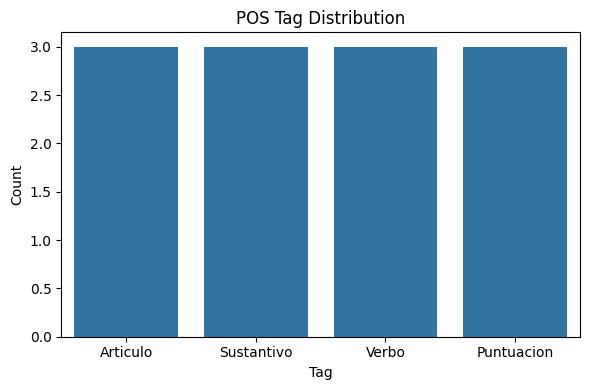

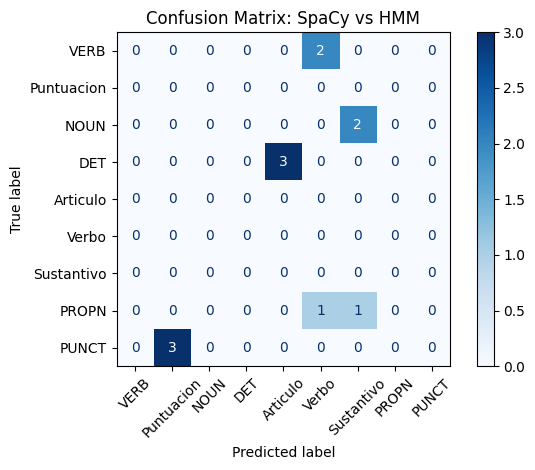

In [10]:
# Visualización de la distribución de etiquetas y comparación con SpaCy

pos_counts = Counter(tags)
plt.figure(figsize=(6, 4))
sns.barplot(x=list(pos_counts.keys()), y=list(pos_counts.values()))
plt.title("POS Tag Distribution")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

try:
    import spacy
    nlp = spacy.load("es_core_news_sm")
    doc = nlp(" ".join(observations))
    spacy_tags = [token.pos_ for token in doc if token.text in observations]

    common_len = min(len(spacy_tags), len(tags))
    aligned_spacy = spacy_tags[:common_len]
    aligned_hmm = tags[:common_len]

    cm = confusion_matrix(aligned_spacy, aligned_hmm, labels=list(set(aligned_spacy + aligned_hmm)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(aligned_spacy + aligned_hmm)))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix: SpaCy vs HMM")
    plt.tight_layout()
    plt.show()
except:
    print("[Opcional] Para comparar con SpaCy, instale la librería y corra el siguiente comando: python -m spacy download es_core_news_sm")

# Para descargar el modelo de SpaCy, puedes usar el siguiente comando en una celda de Jupyter o en la terminal:
# !pip install spacy
# !python -m spacy download es_core_news_sm

### 3. Embeddings con CBOW

En este ejercicio implementaremos el algortimo de retropropagación para entrenar redes neuronales y más adelante, entrenaremos una red neuronal que codifique palabras en vectores usando el método CBOW.

In [11]:
# Importamos librerías necesarias

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

Antes de implementar la retropropagación, definimos la función sigmoide y su derivada.

In [12]:
# Definimos la función de activación sigmoide y su derivada

def sigmoid(x):
    """
    Calcula la función de activación sigmoide.

    Args:
        x (float or np.ndarray): Valor de entrada.

    Returns:
        float or np.ndarray: Valor transformado por la función sigmoide.
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """
    Calcula la derivada de la función sigmoide.

    Args:
        x (float or np.ndarray): Valor de entrada.

    Returns:
        float or np.ndarray: Derivada de la función sigmoide.
    """
    return x * (1 - x)

Con el fin de simplificar el ejercicio, vamos a entrenar una red neuronal que opere como una compuerta XOR. Estas compuertas son de gran utilidad para visualizar redes neuronales de más de una capa.

In [13]:
# Generamos datos de la compuerta XOR e inicializamos los pesos y bias

X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])
np.random.seed(1)
W1 = 2 * np.random.random((2, 4)) - 1
W2 = 2 * np.random.random((4, 1)) - 1

Ahora entrenamos el modelo para que encuentre los parámetros óptimos usando gradient descent.

In [14]:
# Enterenamos la red neuronal

lr = 0.1
for epoch in range(10000):

    L1 = sigmoid(np.dot(X, W1))
    L2 = sigmoid(np.dot(L1, W2))

    error = y - L2
    delta2 = error * sigmoid_derivative(L2)
    delta1 = delta2.dot(W2.T) * sigmoid_derivative(L1)

    W2 += lr * L1.T.dot(delta2)
    W1 += lr * X.T.dot(delta1)

print("Predicciones:", sigmoid(np.dot(sigmoid(np.dot(X, W1)), W2)))

Predicciones: [[0.09581334]
 [0.91580613]
 [0.91080945]
 [0.09593608]]


Estas predicciones se ajustan a nuestras expectativas de la compuerta XOR.

Ahora seguimos con el uso de redes neuronales para aprender embeddings de palabras usando el método CBOW.

In [15]:
# Definimos vocabulario y asignamos índices a palabras

text = "Estamos aprendiendo sobre el modelo cbow y las redes neuronales"
words = text.lower().split()
vocab = list(set(words))
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for word, i in word_to_ix.items()}

In [16]:
# Preparamos los datos de entrenamiento con una ventana de contexto de tamaño 1

data = []
for i in range(1, len(words) - 1):
    context = [words[i - 1], words[i + 1]]
    target = words[i]
    data.append((context, target))

In [17]:
# Definimos una clase para el modelo CBOW

class CBOW(nn.Module):
    """
    Implementa el modelo Continuous Bag of Words (CBOW) usando PyTorch para aprender embeddings de palabras.

    Args:
        vocab_size (int): Tamaño del vocabulario.
        embed_dim (int): Dimensión de los embeddings.
    """
    def __init__(self, vocab_size, embed_dim):
        """
        Inicializa las capas del modelo CBOW.

        Args:
            vocab_size (int): Tamaño del vocabulario.
            embed_dim (int): Dimensión de los embeddings.
        """
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Linear(embed_dim, vocab_size)

    def forward(self, context_idxs):
        """
        Realiza la pasada hacia adelante del modelo CBOW.

        Args:
            context_idxs (torch.Tensor): Índices de las palabras de contexto.

        Returns:
            torch.Tensor: Predicción de la palabra objetivo.
        """
        embeds = self.embeddings(context_idxs)
        context_vec = embeds.mean(dim=0)
        out = self.linear(context_vec)
        return out

In [18]:
# Construimos el modelo, definimos la función de pérdida y el optimizador, y entrenamos el modelo

model = CBOW(len(vocab), 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(100):
    total_loss = 0
    for context, target in data:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        target_idx = torch.tensor([word_to_ix[target]], dtype=torch.long)

        model.zero_grad()
        log_probs = model(context_idxs)
        loss = loss_fn(log_probs.view(1, -1), target_idx)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

print("Embedding para'cbow':", model.embeddings.weight[word_to_ix['cbow']])

Epoch 0, Loss: 20.0009
Epoch 20, Loss: 12.9782
Epoch 40, Loss: 8.9219
Epoch 60, Loss: 6.4164
Epoch 80, Loss: 4.7644
Embedding para'cbow': tensor([ 1.2175,  0.9246, -0.1705,  0.0571,  1.4641, -0.1796, -1.0530, -1.0900,
         0.5789, -1.3024], grad_fn=<SelectBackward0>)
